<a href="https://colab.research.google.com/github/camulro/Aprendizaje-II/blob/sesi%C3%B3n2/AE_Denoise_Fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports
import os
import torch 
import torchvision
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
# constants
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
BATCH_SIZE = 16
NOISE_FACTOR = 0.5

In [ ]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [ ]:
trainset = datasets.FashionMNIST(
    root='./fashion_data',
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root='./fashion_data',
    train=False,
    download=True,
    transform=transform
)
trainloader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
testloader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

print('Training: {} samples, Test: {} samples'.format(len(trainset), len(testset)))

Extracting ./fashion_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fashion_data/FashionMNIST/raw


Extracting ./fashion_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fashion_data/FashionMNIST/raw



Extracting ./fashion_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fashion_data/FashionMNIST/raw


Extracting ./fashion_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fashion_data/FashionMNIST/raw
Processing...
Done!
Training: 60000 samples, Test: 10000 samples


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# choose device
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
print(device)

cuda:0


In [ ]:
# the autoencoder network
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)  
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.ConvTranspose2d(64, 1, kernel_size=3, padding=1)
    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.pool(x)
        x = F.relu(self.enc4(x))
        x = self.pool(x) # the latent space representation
        
        # decode
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = torch.sigmoid(self.out(x))
        return x
net = Autoencoder().to(device)
print(net)

Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [ ]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [ ]:
#training
net.train()
train_loss = []
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for data in trainloader:
        img, _ = data # we do not need the image labels
        # add noise to the image data
        img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
        # clip to make the values fall between 0 and 1
        img_noisy = np.clip(img_noisy, 0., 1.)
        img_noisy = img_noisy.to(device)
        optimizer.zero_grad()
        outputs = net(img_noisy)
        loss = criterion(outputs, img_noisy)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()*img.size(0)
        
    loss = running_loss / len(trainloader)
    train_loss.append(loss)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))


Epoch 1 of 10, Train Loss: 0.958
Epoch 2 of 10, Train Loss: 0.877
Epoch 3 of 10, Train Loss: 0.866
Epoch 4 of 10, Train Loss: 0.860
Epoch 5 of 10, Train Loss: 0.856
Epoch 6 of 10, Train Loss: 0.853
Epoch 7 of 10, Train Loss: 0.851
Epoch 8 of 10, Train Loss: 0.849
Epoch 9 of 10, Train Loss: 0.848
Epoch 10 of 10, Train Loss: 0.847


In [ ]:
#evaluation of one batch
net.eval()
dataiter = iter(testloader)
img, _ = dataiter.next()
img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
img_noisy = np.clip(img_noisy, 0., 1.)
img_noisy = img_noisy.to(device)
output = net(img_noisy)

#reshape to [batch_size, 1, 28, 28] to display output image
output = output.view(outputs.size(0), 1, 28, 28).data
output = output.cpu().detach().numpy()


    


Original Images


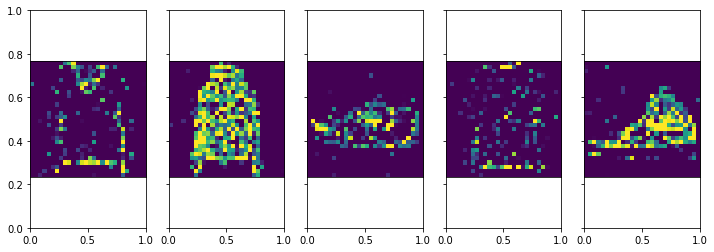

Reconstructed Images


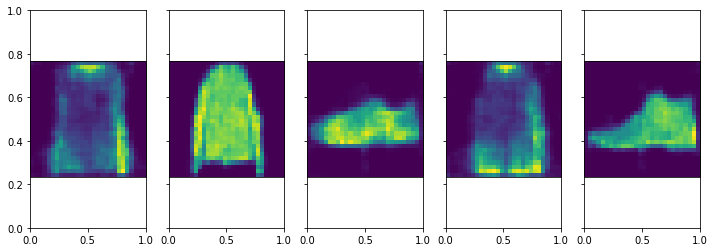

In [ ]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  #undo normalization
    plt.imshow(np.transpose(img, (1, 2, 0)).squeeze())

# Plot

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(img_noisy[idx].cpu().numpy())
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
plt.show() 